In [49]:
%load_ext autoreload
%autoreload 2

import numpy as np
import imageio
import cv2
import glob
import os

import open3d as o3d
from pyquaternion import Quaternion
import matplotlib.pyplot as plt

from MatlabTests.python.read_write_model import *
from MatlabTests.python.read_dense import *

from Bastian_utils.ShowUtils import *
from Bastian_utils.FloorSegment import *
from Bastian_utils.VideoUtils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Cut videos to image frames

In [24]:
video_path = "../Food/videos/VID_20200922_090157.mp4"
save_path = '../Food/work_space/images/'

b_recut = False
if b_recut:
    video_cutter(video_path, save_path, 150)

### Colmap reconstruction 

![food colmap result](images/colmap_food.png)

This raw result could not be used directly

# 2. Post-processing the mvs results

In [25]:
worksapce_path = "../Food/work_space/"
images_all = glob.glob(worksapce_path+ "/mvs/images/*.jpg")
print("==> Loaded", len(images_all), "images")

==> Loaded 40 images


In [26]:
input_model = worksapce_path + "/mvs/sparse"
input_format = ".bin"
image_folder = worksapce_path + "/mvs/images/"
depth_folder = worksapce_path + "/mvs/stereo/depth_maps/"

In [27]:
cameras, images, points3D = read_model(path=input_model, ext=input_format)
print("num_cameras:", len(cameras))
print("num_images:", len(images))
print("num_points3D:", len(points3D))

num_cameras: 2
num_images: 40
num_points3D: 1498


## 2.1 Depth denoise

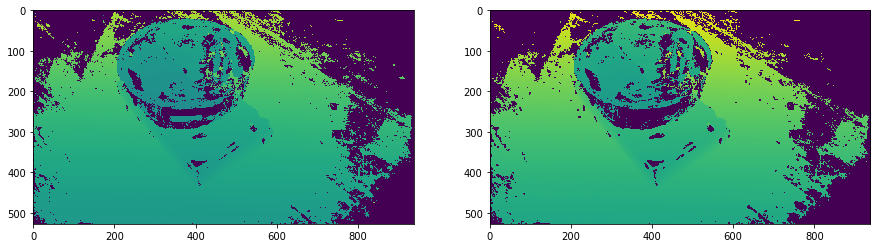

In [42]:
idx = 21
depth_path = depth_folder + "/" + str(idx) + '.jpg.geometric.bin'
depth = read_array(depth_path)

depth_filtered = denoise_depth(depth, 0, False)

plt.figure(figsize=(15,5))
plt.subplot(121); plt.imshow(depth)
plt.subplot(122); plt.imshow(depth_filtered)

## 2.1 TV result

In [68]:
camera_parameter = [960,540,943.53,943.53,469,236.5]
depth_path = worksapce_path + "/tv/" + str(idx) + '_admm.npy'
depth_tv = np.load(depth_path)
cloud, colors = image_depth_to_pointcloud(cv2.imread(image_path), depth_tv, camera_parameter)
point_cloud_o3d = o3d.geometry.PointCloud()
point_cloud_o3d.points = o3d.utility.Vector3dVector(cloud)
point_cloud_o3d.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([point_cloud_o3d])

In [33]:
def test_floor_deletion(idx, camera_param):
    depth_path = depth_folder + "/" + str(idx) + '.jpg.geometric.bin'
    image_path = image_folder + "/" + str(idx) + '.jpg'

    camera_mtx = np.array([[camera_param[0],0,camera_param[2]],
                                [0,camera_param[1],camera_param[3]],
                                [0,0,1]])
    
    image = cv2.imread(image_path)
    depth = read_array(depth_path)
    image = cv2.resize(image, (depth.shape[1], depth.shape[0]))

    result = floor_repairment_o3d(depth, np.zeros(depth.shape), camera_mtx, False)
    #print(result)
    
    plt.figure(figsize=(15,7))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(image, 4))

    plt.subplot(132)
    plt.imshow(depth)
    
    plt.subplot(133)
    plt.imshow(result)

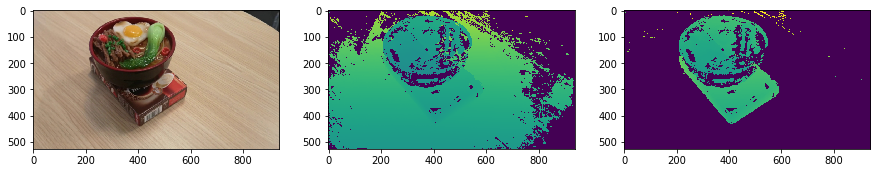

In [32]:
camera_param = cameras[1].params
idx = 21
depth_path = depth_folder + "/" + str(idx) + '.jpg.geometric.bin'
image_path = image_folder + "/" + str(idx) + '.jpg'

camera_mtx = np.array([[camera_param[0],0,camera_param[2]],
                                [0,camera_param[1],camera_param[3]],
                                [0,0,1]])
    
image = cv2.imread(image_path)
depth = read_array(depth_path)
image = cv2.resize(image, (depth.shape[1], depth.shape[0]))

result = test_floor_deletion(depth, camera_mtx)

plt.figure(figsize=(15,7))
plt.subplot(131)
plt.imshow(cv2.cvtColor(image, 4))

plt.subplot(132)
plt.imshow(depth)
    
plt.subplot(133)
plt.imshow(result)

In [61]:
volume = o3d.integration.ScalableTSDFVolume(
    voxel_length=0.30 / 512.0,
    sdf_trunc=0.005,
    color_type=o3d.integration.TSDFVolumeColorType.RGB8)

count = 1
for image_id, Image in images.items():
    camera_param = cameras[Image.camera_id].params
    pose_camera = q_t_to_matrix(Image.qvec, Image.tvec*0.1) #np.linalg.inv
    image_file = image_folder + "/" + Image.name
    depth_file = depth_folder + "/" + Image.name + '.geometric.bin'
    #print(image_file, depth_file)
    
    image_id = int(Image.name[:-4].split("/")[-1])
    folder_name = Image.name[:-4].split("/")[0]
    if(not os.path.exists(depth_file)):
        continue
    
    color = o3d.io.read_image(image_file)

    camera_mtx = np.array([[camera_param[0],0,camera_param[2]],
                            [0,camera_param[1],camera_param[3]],
                            [0,0,1]])
    
    image = cv2.imread(image_file)
    depth_py = read_array(depth_file)*100
    #depth_py = delete_underground_points(depth_py, camera_mtx)*100
    depth_buffer = depth_py.astype(np.float32).copy()
    depth_buffer = cv2.resize(depth_buffer, (image.shape[1], image.shape[0]), cv2.INTER_NEAREST)
    
    depth = o3d.geometry.Image(depth_buffer)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
                color, depth, depth_trunc=4.0, convert_rgb_to_intensity=False)
    
    volume.integrate(
        rgbd_image,
        o3d.camera.PinholeCameraIntrinsic(depth_buffer.shape[1], depth_buffer.shape[0], camera_param[0], camera_param[1], camera_param[2], camera_param[3]),
        pose_camera)
    print("\r current process frame :["+str(count)+"/"+str(len(images))+"]", end="", flush= True)
    count += 1

 current process frame :[40/40]

In [64]:
print("Extract a triangle mesh from the volume and visualize it.")
mesh = volume.extract_triangle_mesh()
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])

Extract a triangle mesh from the volume and visualize it.


In [63]:
o3d.io.write_triangle_mesh("../Food/work_space/o3d_mesh.ply", mesh)

True